In [1]:
import os
import time

import umap
import numpy as np
import pandas as pd
import scanpy as sc
import MACA as maca

from scipy import io
from scipy.sparse import csr_matrix

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
adata_spatial_anterior = sc.datasets.visium_sge(
    sample_id="V1_Mouse_Brain_Sagittal_Anterior"
)
adata_spatial_anterior.var_names_make_unique()
sc.pp.normalize_total(adata_spatial_anterior, inplace=True)
sc.pp.log1p(adata_spatial_anterior)
sc.pp.highly_variable_genes(adata_spatial_anterior, flavor="seurat", n_top_genes=5000, inplace=True)
adata_spatial_posterior = sc.datasets.visium_sge(
    sample_id="V1_Mouse_Brain_Sagittal_Posterior"
)
adata_spatial_posterior.var_names_make_unique()
sc.pp.normalize_total(adata_spatial_posterior, inplace=True)
sc.pp.log1p(adata_spatial_posterior)
sc.pp.highly_variable_genes(adata_spatial_posterior, flavor="seurat", n_top_genes=5000, inplace=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
adata_spatial_anterior.obs['Study']='Anterior'
adata_spatial_posterior.obs['Study']='Posterior'
adata = adata_spatial_anterior.concatenate(adata_spatial_posterior)

In [5]:
markers = pd.read_csv("ReferenceMarkers/mouse_cortex_allen_markers.csv",header=0,index_col=False)
cell_markers={}
for m in markers.columns:
    cell_markers[m]=markers[m].values.tolist()

In [6]:
##run MACA
marker_list = []
for k, v in cell_markers.items():
    marker_list += v
marker_list = list(set(marker_list))
marker_list = [i for i in marker_list if i in adata.var.index]
len(marker_list)
ad = adata[:,marker_list].copy()

start_time = time.time()
ad, annotation = maca.singleMACA(ad=ad, cell_markers=cell_markers,
                                 res=[1,2,3],n_neis=[3,5,10])
print("--- %s mins ---" % int((time.time() - start_time)/60))

(6050, 23)
--- 4 mins ---


In [7]:
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=100)

... storing 'Study' as categorical
... storing 'Annotation' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


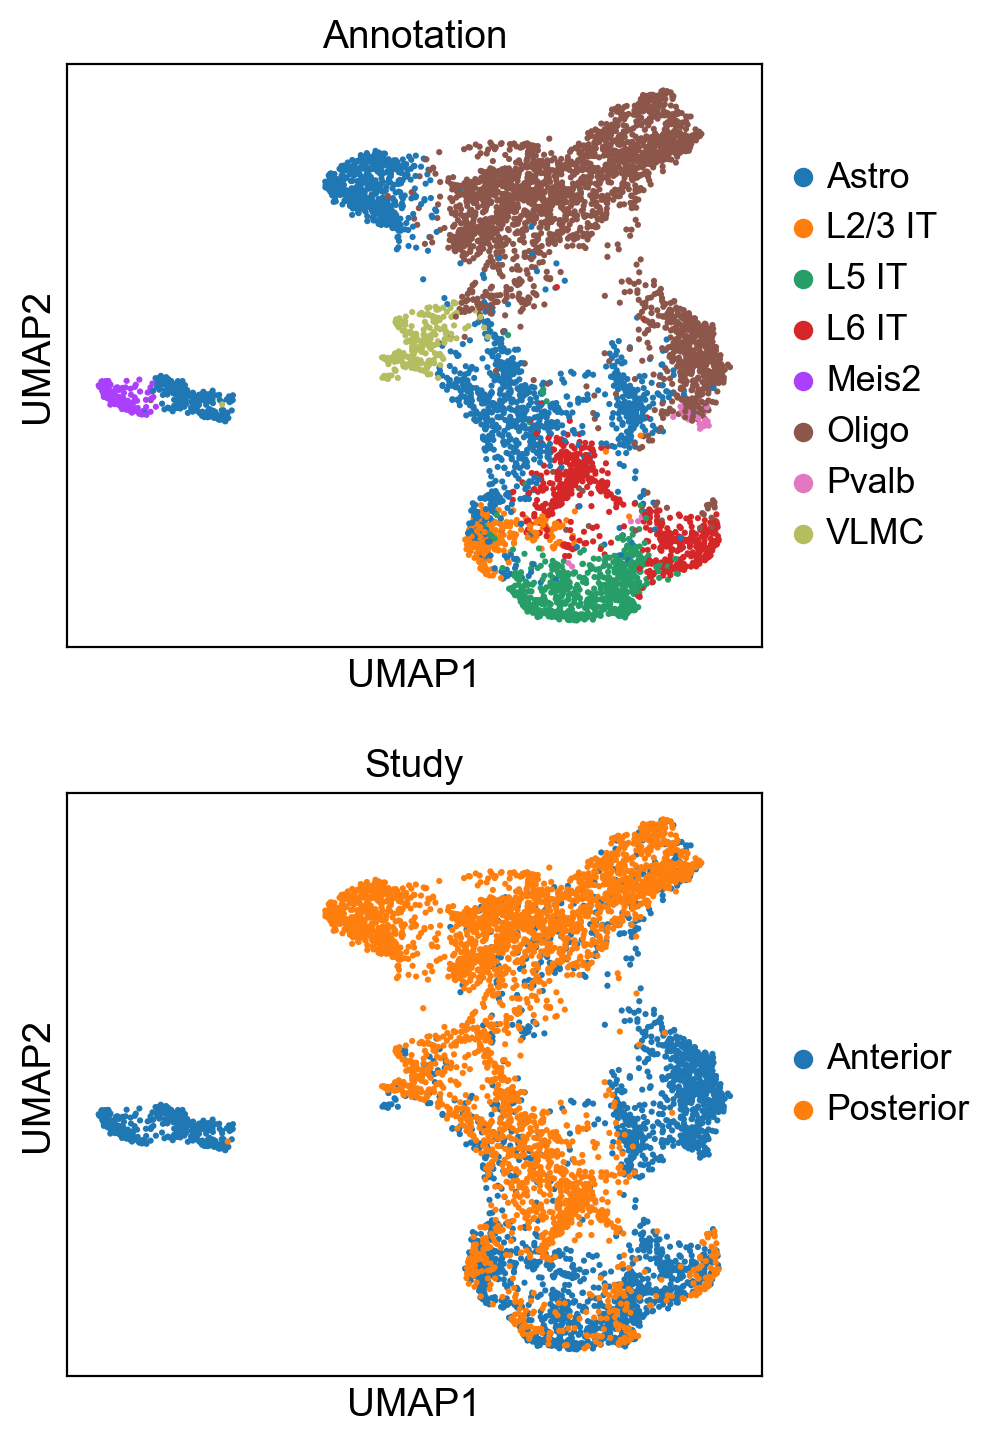

In [8]:
##visualization
adata.obsm['X_umap']=ad.obsm['X_umap']
adata.obs['Annotation']=annotation
sc.pl.umap(adata, color=["Annotation",'Study'],ncols=1)

... storing 'Study' as categorical
... storing 'Annotation' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


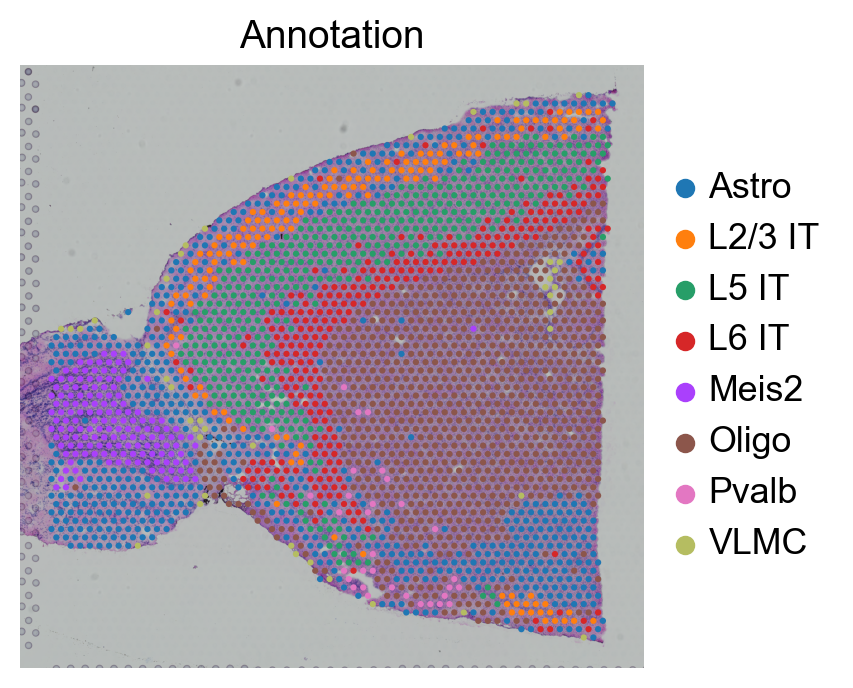

In [9]:
adata_spatial_anterior.obs['Annotation']=annotation[adata.obs['Study']=='Anterior']
adata_spatial_posterior.obs['Annotation']=annotation[adata.obs['Study']!='Anterior']
sc.pl.spatial(adata_spatial_anterior, color="Annotation", frameon=False)

... storing 'Study' as categorical
... storing 'Annotation' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


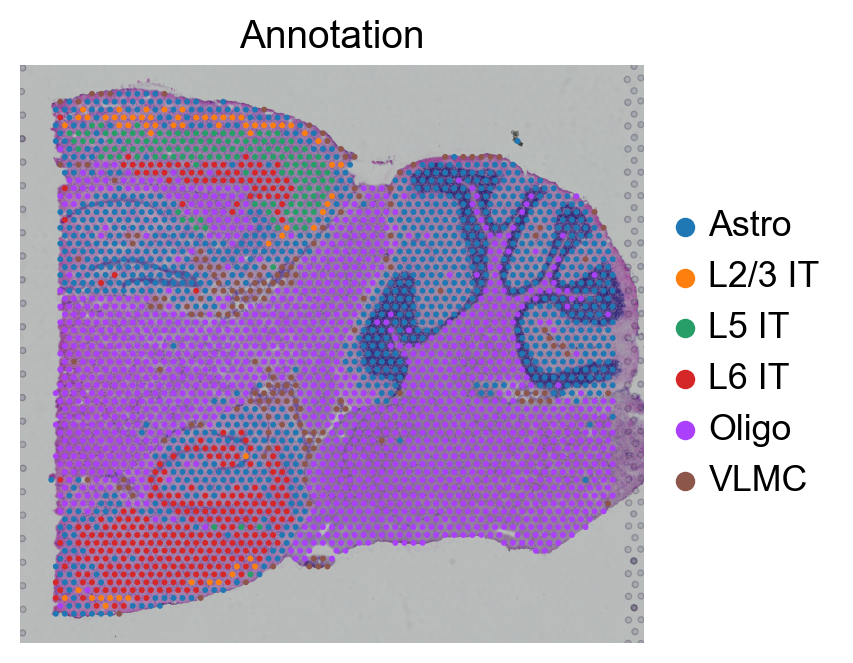

In [10]:
sc.pl.spatial(adata_spatial_posterior, color="Annotation", frameon=False)